# **1) Data Preparation**

From the original full BindingDB database, we extracted a smaller, more manageable dataset by selecting only ligand-target pairs studied on viral organisms associated with sexually transmitted diseases, such as Human Immunodeficiency Virus (HIV). This subset is saved in the same `.tsv` file format as the original database.

For more details on the extraction process, refer to [`./src/data/std_extraction.ipynb`](./src/data/std_extraction.ipynb).


In [5]:
#import libraries and scripts

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import data_utils, evaluation_utils
from src.data.some_dataloader import get_dataset
from src.scripts import rdkit_extraction
from src.utils import evaluation_utils

#imports to get rid of Morgan Fingerprint warnings
import warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.warning')

#set seaborn palette
sns.set_palette('colorblind')

We import the reduced dataset with the custom dataloader `get_dataset`. The reduced dataset contains only viruses responsible for STDs as target organisms

In [15]:
#read the std database

df = get_dataset()
print(f'STDs dataset rows: {df.shape[0]}')
print(f'STDs dataset columns: {df.shape[1]}')

STDs dataset rows: 30156
STDs dataset columns: 86


In the dataset, four affinity metric are available:

1. **Ki (Inhibition Constant)**: Represents the concentration at which an inhibitor ligand occupies 50% of the receptor or enzyme sites, assuming no competing ligands are present. It quantifies the affinity of the inhibitor for the target under equilibrium conditions.

2. **IC50 (Half Maximal Inhibitory Concentration)**: Represents the concentration of a drug needed to inhibit a specific biological or biochemical function by 50%. It measures how much drug is required to achieve a halfway inhibition of the target activity in a given experimental setup.

3. **Kd (Dissociation Constant)**: Represents the concentration at which 50% of the binding sites on the target (e.g., receptor or enzyme) are occupied by the ligand. It quantifies the equilibrium affinity between a ligand and its target, with lower values indicating tighter binding.

4. **EC50 (Half Maximal Effective Concentration)**: Represents the concentration of a drug needed to produce 50% of its maximal effect in a biological system. It is an indicator of the drug's potency, reflecting the concentration required to achieve a halfway maximal response.

These metrics are interrelated but not directly interchangeable, although an approximate relationship between **Ki** and **IC50**, the Cheng-Prusoff equation, does exist. Unfortunately, strict conditions need to be satisfies, so we won't use it in our analysis.

Therefore, in the next cells we will select the most represented metric in our dataset and get rid of rows where it's not provided.

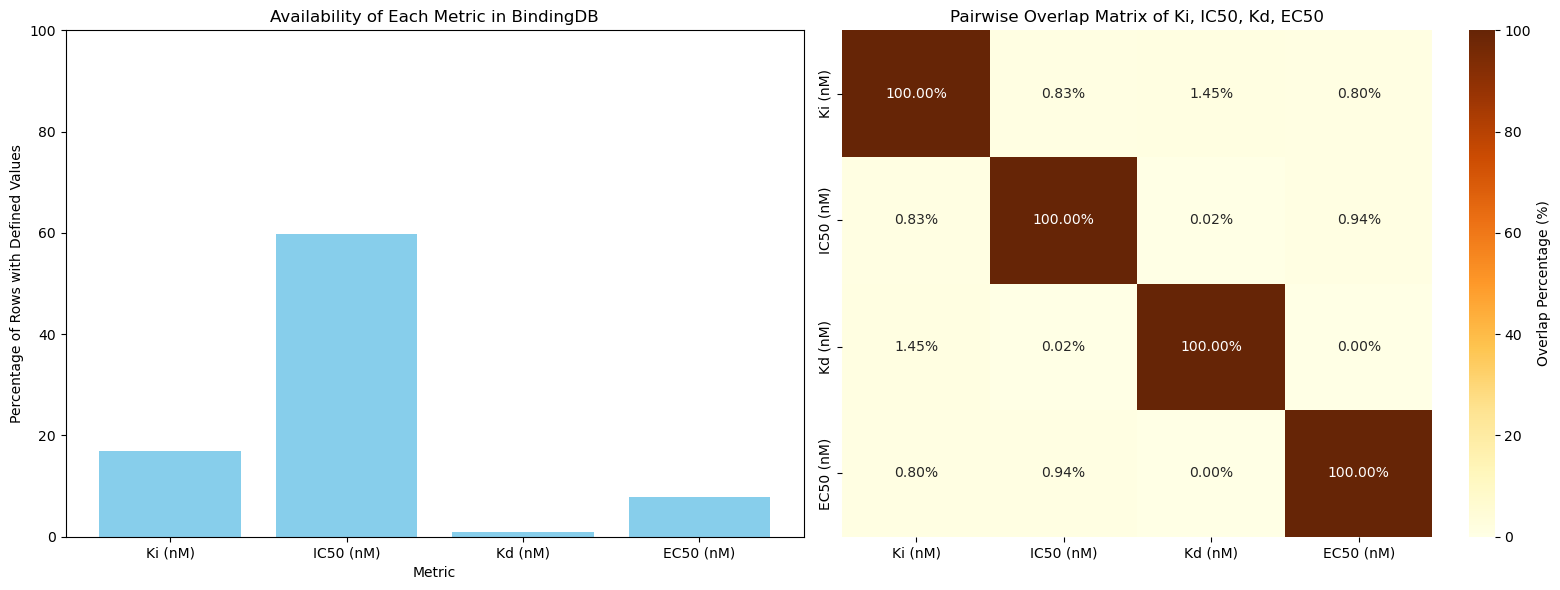

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax = axes.flatten()

evaluation_utils.plot_metric_availability(df, ax=ax[0])
evaluation_utils.plot_overlap_matrix(df, ax=ax[1])

plt.tight_layout()
plt.show()

We observe that IC50 is given in more than 50% of the rows, while the other metrics are less represented. In the overlap matrix, we also observe that metrics rarely overlap, so it makes sense to pick only one of the four for the analysis.  

In the next cell, we use the `data_utils.select_metric` function to select only rows with IC50 for our analyses.  

We also get rid of columns where more than 50% of entries are `NaN` through the `data_utils.clean_na_columns` function. Non-numeric entries that were not `NaN` (e.g., `'> 50000'`) were also removed, since they would negatively affect the computation of statistics like the mean.



In [24]:
df = data_utils.select_metric(df, 'IC50 (nM)')
df = data_utils.clean_na_columns(df)
print(f'Rows of STD dataset where IC50 is given: {df.shape[0]}')
print(f'Columns of STD dataset where nan rows are less than 50% of the total: {df.shape[1]}')

Rows of STD dataset where IC50 is given: 18026
Columns of STD dataset where nan rows are less than 50% of the total: 27


Let's now plot with the `evaluation_utils.plot_organism_counts` function the frequencies of entries for all targets. The distribution we obtain is skewed, so we employ a logarithmic scale

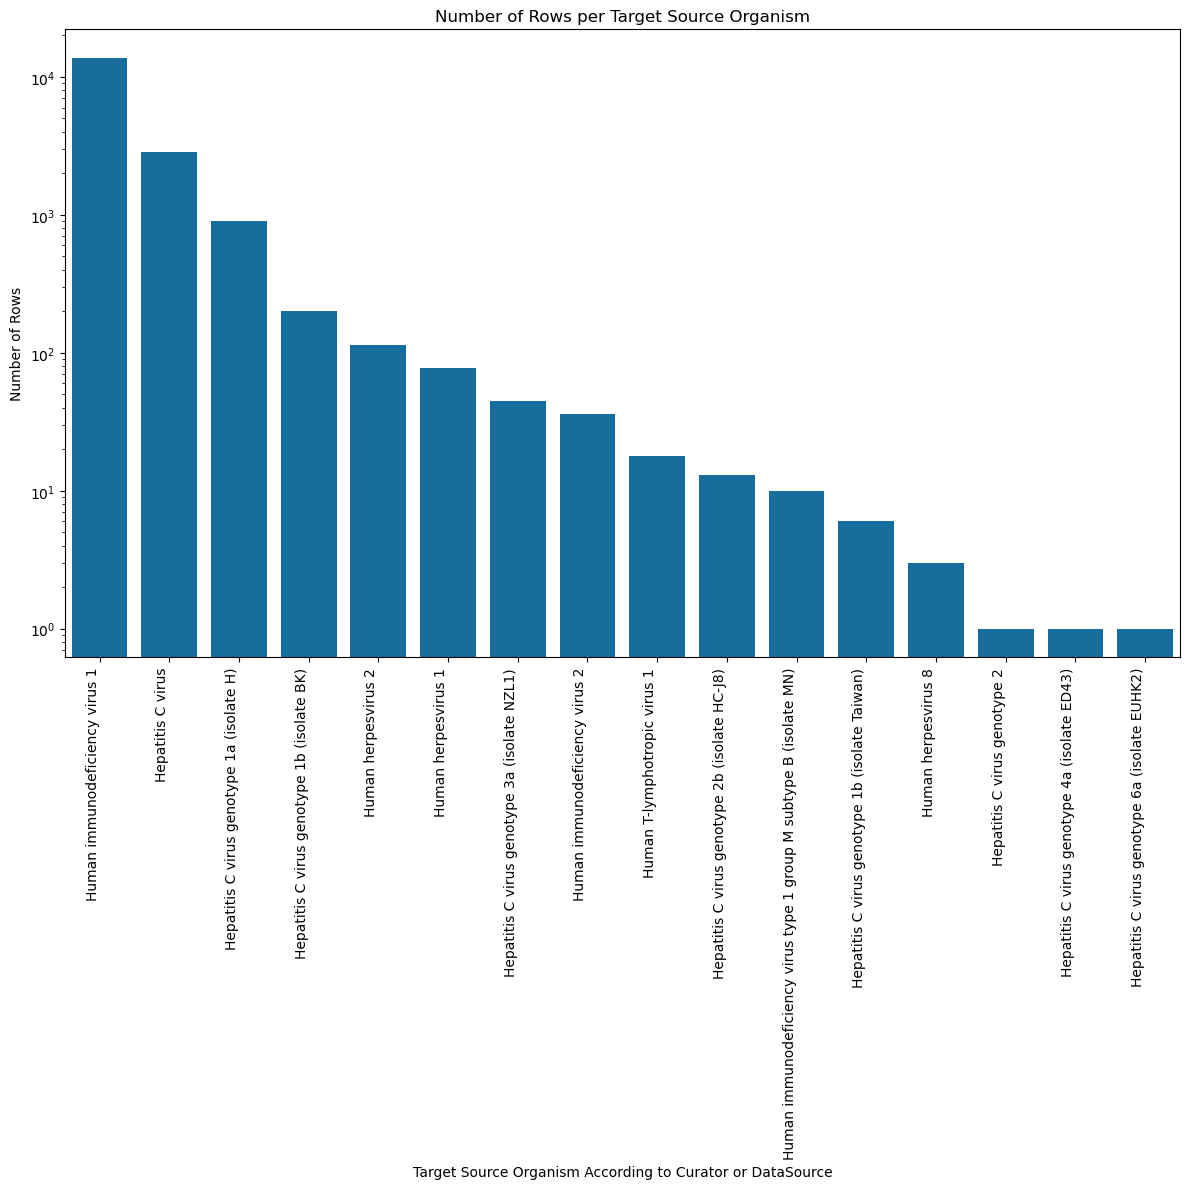

In [36]:
evaluation_utils.plot_organism_counts(df)

We observe that HIV 1 is clearly the most represented in the dataset (this type accounts for more than 95% of HIV infections worldwide (see https://doi.org/10.1093/infdis/jiad327)). The second most represented in the dataset is Hepatitis C virus.

This study focuses on the HIV 1 subset of sexually transmitted diseases (STDs), investigating how specific features influence the affinity of STD drugs. The analyzed features include Year, Institution, Molecular Features, Types of Drugs, and Type of Protein Target. These features were selected because they represent critical aspects of drug development and application, offering a solid foundation for understanding patterns and structures associated with drug affinity.

Additionally, a comparative analysis with Hepatitis C will be conducted to identify differences and similarities with HIV 1, providing broader context and depth to the analysis.

By focusing on these two viruses, we aim to underscore their social relevance by addressing the ongoing global health challenges they pose and shedding light on opportunities to improve therapeutic strategies for diseases that disproportionately affect vulnerable populations. STDs.

In [ ]:
#Let's create a new `hiv` dataframe, containing only rows where the target is `Human immunodeficiency virus 1`
hiv = df[df['Target Source Organism According to Curator or DataSource'] == 'Human immunodeficiency virus 1']
print(f'HIV1 dataset rows: {hiv.shape[0]}')
print(f'HIV1 dataset columns: {hiv.shape[1]}')
#let's do it for Hepatites C
##LEONORS CODE

# **2) Feature analysis**

The features we are going to analyze are:

- **Year**: To examine temporal trends in drug affinity, such as advancements in treatment effectiveness or changes in focus over time.
- **Institution**: To explore the contributions of different research organizations, including geographic and resource-based disparities, to the development of STD drugs.
- **Molecular Features**: To assess how the chemical and biological properties of compounds influence their affinity for STD-related targets.
- **Types of Drugs**: To classify and compare the effectiveness of different drug categories (e.g., antiretrovirals or antivirals) in treating STDs.
- **Type of Protein Target**: To understand the interaction between drugs and specific biological targets, providing insights into the mechanisms driving drug efficacy.


## **Molecular Features**

## **Molecular Features**

## **Molecular Features**

## **Molecular Features**

# **3) Compartive analysis**